In [8]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from AudioDataset import AudioDataset
import torch.optim as optim
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for GPU acceleration.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for GPU acceleration.")
else:
    device = torch.device("cpu")
    print("No GPU device found. Using CPU.")

Using MPS device for GPU acceleration.


In [10]:
import random

random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [11]:
class SpeechEfficientNet(nn.Module):
    def __init__(self, n_classes=12, dropout_rate=0.3):
        super().__init__()
        
        # Load pre-trained EfficientNet-B0 model
        self.efficientnet = models.efficientnet_b0(weights='DEFAULT')
        
        # Modify first conv layer to accept 1 channel instead of 3
        # while preserving weights from first channel
        original_conv = self.efficientnet.features[0][0]
        self.efficientnet.features[0][0] = nn.Conv2d(
            1, 32, kernel_size=3, stride=2, padding=1, bias=False
        )
        with torch.no_grad():
            self.efficientnet.features[0][0].weight = nn.Parameter(
                original_conv.weight[:, 0:1, :, :]
            )
        
        # Get feature dim (1280 for B0) and replace classifier with identity
        num_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(num_features, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(64, n_classes)
        )
    
    def forward(self, x):
        # Reshape: B×T×M → B×1×M×T
        x = x.transpose(1, 2).unsqueeze(1)  
        
        # Extract features
        x = self.efficientnet.features(x)
        
        # Apply attention
        attn = self.attention(x)
        attended = x * attn
        
        # Classify
        return self.classifier(attended)


In [12]:
train_set = AudioDataset(csv_path="./data/train_balanced.csv", audio_dir="./data_raw/train/audio")
# ─── train loader ────────────────────────────────────────────────────────
train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=4
)
# ─── test loader ────────────────────────────────────────────────────────
test_set = AudioDataset("./data/test.csv", "./data_raw/train/audio")
test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=4
)

In [13]:
# # ─── prepare dataset ──────────────────────────────────────────────────────
# train_set = AudioDataset("./data/train_balanced.csv", "./data_raw/train/audio")
# labels = [lbl for _, lbl in train_set]              # list of ints
# counts = torch.bincount(torch.tensor(labels))       # #samples per class

# train_loader = DataLoader(
#     train_set,
#     batch_size=128,
#     drop_last=True
# )

# # ─── test loader ────────────────────────────────────────────────────────
# test_set = AudioDataset("./data/test.csv", "./data_raw/train/audio")
# test_loader = DataLoader(
#     test_set,
#     batch_size=128,
#     shuffle=False,
#     drop_last=False
# )

In [14]:
model = SpeechEfficientNet(n_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    running = 0.0
    for i, (spec, labels) in enumerate(train_loader):
        spec, labels = spec.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(spec), labels)
        loss.backward()
        optimizer.step()
        running += loss.item()
        if i % 10 == 0:
            print(f"Batch {i}, Loss: {loss.item():.4f}")
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running/len(train_loader):.4f}")

Batch 0, Loss: 2.4979
Batch 10, Loss: 2.4222
Batch 20, Loss: 2.1792
Batch 30, Loss: 1.7216
Batch 40, Loss: 1.2089
Batch 50, Loss: 1.2633
Batch 60, Loss: 0.9208
Batch 70, Loss: 0.9165
Batch 80, Loss: 0.8116
Batch 90, Loss: 0.6289
Batch 100, Loss: 0.6639
Batch 110, Loss: 0.5256
Batch 120, Loss: 0.5089
Batch 130, Loss: 0.5955
Batch 140, Loss: 0.5506
Batch 150, Loss: 0.4900
Batch 160, Loss: 0.5714
Epoch 1, Loss: 1.0439
Batch 0, Loss: 0.2579
Batch 10, Loss: 0.3751
Batch 20, Loss: 0.3200
Batch 30, Loss: 0.3246
Batch 40, Loss: 0.2905
Batch 50, Loss: 0.3743
Batch 60, Loss: 0.3902
Batch 70, Loss: 0.4873
Batch 80, Loss: 0.3111
Batch 90, Loss: 0.3243
Batch 100, Loss: 0.3248
Batch 110, Loss: 0.2664
Batch 120, Loss: 0.1957
Batch 130, Loss: 0.3173
Batch 140, Loss: 0.3138
Batch 150, Loss: 0.2963
Batch 160, Loss: 0.3795
Epoch 2, Loss: 0.3427
Batch 0, Loss: 0.3376
Batch 10, Loss: 0.3243
Batch 20, Loss: 0.2037
Batch 30, Loss: 0.3430
Batch 40, Loss: 0.1262
Batch 50, Loss: 0.1986
Batch 60, Loss: 0.2017
Ba

In [15]:
model.eval()
classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]
all_preds, all_labels = [], []
n_correct = n_samples = 0
class_correct = [0]*12
class_total = [0]*12
with torch.no_grad():
    for spec, labels in test_loader:
        spec, labels = spec.to(device), labels.to(device)
        preds = model(spec).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        n_samples += labels.size(0)
        n_correct += (preds == labels).sum().item()
        for l, p in zip(labels, preds):
            class_total[l] += 1
            if l == p: class_correct[l] += 1
    print(f"Accuracy: {100*n_correct/n_samples:.2f}%")
    for i,c in enumerate(classes):
        print(f'Class "{c}": {100*class_correct[i]/class_total[i]:.2f}%')

Accuracy: 90.93%
Class "yes": 96.48%
Class "no": 91.67%
Class "up": 96.69%
Class "down": 90.91%
Class "left": 95.51%
Class "right": 89.58%
Class "on": 96.75%
Class "off": 94.66%
Class "stop": 97.99%
Class "go": 84.86%
Class "silence": 100.00%
Class "unknown": 89.27%


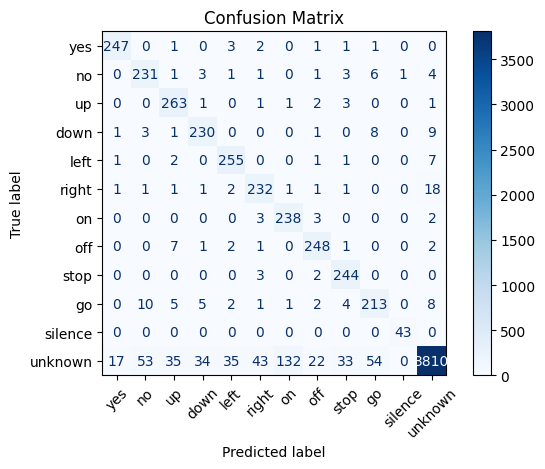

In [16]:
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()